In [5]:
import numpy as np
import math
import cv2
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import tools

from ipywidgets import interact, fixed

def normalize_image(img):
    img = img.astype(float)
    return ( img - np.min(img)) / ( np.max(img) - np.min(img))

def normL1(imgX, imgY):
    return np.abs(imgX) + np.abs(imgY)

def normL2(imgX, imgY):
    return np.sqrt( imgX * imgX + imgY * imgY)

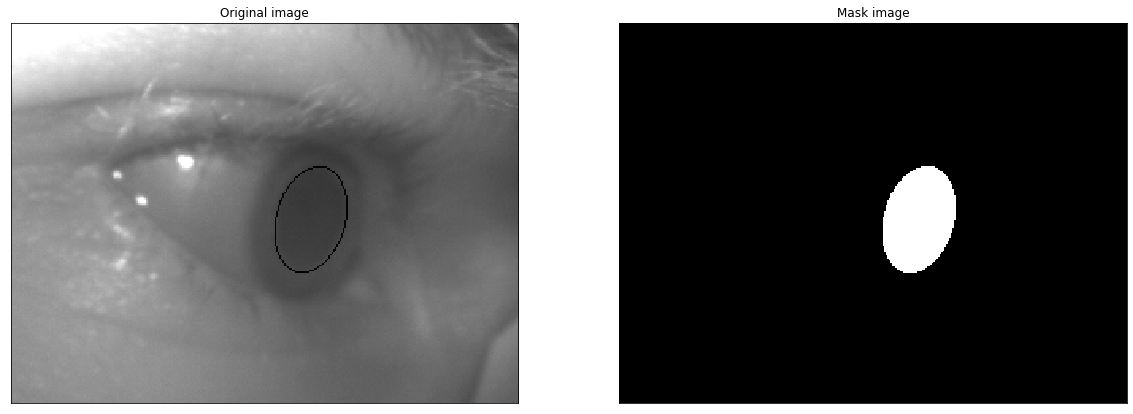

In [6]:
## fit the ellipse and make the mask

img = cv2.imread( '../../train/images/input/elps_eye_1.png', cv2.IMREAD_GRAYSCALE)
image = cv2.imread( '../../train/images/input/elps_eye_1.png', cv2.IMREAD_GRAYSCALE)

height, width = img.shape

mask = np.zeros((height,width,3), np.uint8)
mask[:,:] = (255, 255, 255)

array = np.array([[165.75,106.8984375], [170.75,130.3984375], [185.75,147.3984375], [202.25,145.8984375], [211.25,128.3984375], [208.25,106.3984375], [197.75,90.3984375], [176.75,83.8984375]])


#arr = array.astype(int)
arr = array.astype(np.float32)

##rect : [(xc, yc), (a, b), theta]
rect = cv2.fitEllipse(arr)
#(xc, yc), (a, b), theta = cv2.fitEllipse(arr)

xc = rect[0][0]
yc = rect[0][1]
a = rect[1][0]
b = rect[1][1]
theta = rect[2]

liste = [[xc, yc], [a, b], theta]
liste[0][1] = height - liste[0][1]
tup1 = (liste[0][0], liste[0][1])
tup2 = (liste[1][0], liste[1][1])

rect2 = (tup1, tup2, -liste[2])


# Black color
color = (0, 0, 0) 

cv2.ellipse(img, rect2, color) 
cv2.ellipse(mask, rect2, color, thickness = -1) 

x_c = xc
y_c = height - yc

## Draw white mask on black image:
for y in range(width):
    for x in range(height): 
        if mask[x][y][0] == 255:
            mask[x][y][0] = 0
            mask[x][y][1] = 0
            mask[x][y][2] = 0
        else:
            mask[x][y][0] = 255
            mask[x][y][1] = 255
            mask[x][y][2] = 255

tools.multiPlot( 1, 2, ( img, mask),
                ( 'Original image', 'Mask image'),
                cmap_tuple=( cm.gray, cm.gray))

cv2.imwrite('img.png', img)
cv2.imwrite('mask.png', mask)
mask_img = mask

In [7]:
def get_ellipse_param(img, conn_comp):
    num_labels = conn_comp[0]   # The first cell is the number of labels
    img_labels = conn_comp[1]   # The second cell is the label matrix
    stats = conn_comp[2]        # The third cell is the stat matrix
    centroids = conn_comp[3].astype(int)    # The fourth cell is the centroid matrix
    
    width = img.shape[1]
    height = img.shape[0]
    
    x_range = np.arange(width)
    y_range = np.arange(height)
    x_array, y_array = np.meshgrid(x_range, y_range)
    

    
    # Draw ellipses
    img_elps = cv2.cvtColor( img, cv2.COLOR_GRAY2RGB)
    for label in range( 1, num_labels):
    #for label in range(1,2):
        xc = centroids[label,0]
        yc = centroids[label,1]
        xl = x_array[img_labels == label] - xc
        yl = y_array[img_labels == label] - yc
        n = np.sum(img_labels == label)
        Mxx = np.sum(np.square(xl)) / n
        Myy = np.sum(np.square(yl)) / n
        Mxy = np.sum(xl * yl) / n
        discr = math.sqrt(4.0 * Mxy * Mxy + (Mxx - Myy) ** 2)
        a = int( math.sqrt( 2.0 * ( Mxx + Myy + discr)))
        b = int( math.sqrt( 2.0 * ( Mxx + Myy - discr)))
        theta = int( 0.5 * math.atan2( 2.0 * Mxy, Mxx - Myy) * 180.0 / np.pi)
        #print( 'Label %d: xc = %d, yc = %d, a = %d, b = %d, theta = %d' % ( label, xc, yc, a, b, theta))
        
        cv2.ellipse( img_elps, (xc, yc), (a, b), theta, 0, 360, (255,0,0), thickness=1)
        cv2.circle( img_elps, (xc, yc), 1, (255,0,0), thickness=2)

    return img_elps, a, b, xc, yc, theta

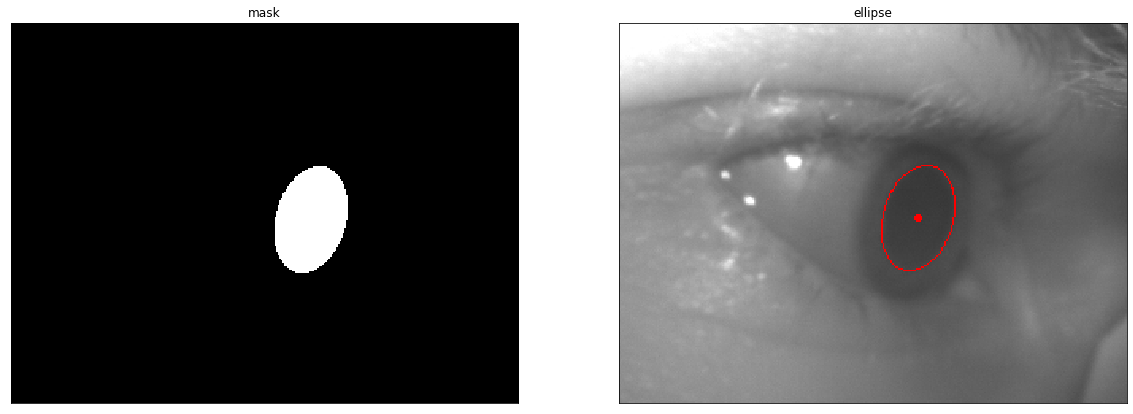

In [9]:
## Get ellipse parameters + draw

connectivity = 4

mask_image = mask_img[...,0]
ret,thresh1 = cv2.threshold(mask_image,100,255,cv2.THRESH_BINARY)

conn_comp = cv2.connectedComponentsWithStats(thresh1, connectivity, cv2.CV_32S)

img_elps, a, b, xc, yc, theta = get_ellipse_param(image, conn_comp)

tools.multiPlot( 1, 2, (mask, img_elps),
                ( 'mask', 'ellipse'),
                cmap_tuple=( cm.gray, cm.gray))